In [38]:
!poetry install

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: mlforscience (0.1.0)
If you do not want to install the current project use --no-root.
If you want to use Poetry only for dependency management but not for packaging, you can disable package mode by setting package-mode = false in your pyproject.toml file.
In a future version of Poetry this warning will become an error!


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import os

# Датасет hotel_reservations представляет собой данные об отмене бронирования отелей

**Бизнес-постановка задачи**: Предсказать, отменит ли клиент бронирование в отеле. 
Это поможет отелям управлять своей загрузкой и минимизировать потери, связанные с пустующими номерами.

**Постановка ML-задачи**: Создать модель бинарной классификации, которая на основе характеристик бронирования 
(например, количество дней до заезда, способ бронирования и т.д.) предскажет вероятность отмены бронирования.

**Данные**: В датасете представлены различные характеристики бронирований, такие как количество ночей, канал бронирования, 
статус отмены и другие атрибуты, достаточные для решения поставленной задачи.

In [40]:
path = os.path.join('..', 'hotel_reservations.csv')

In [41]:
df = pd.read_csv(path)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [43]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [44]:
unique_values = {
    "type_of_meal_plan": df["type_of_meal_plan"].unique(),
    "required_car_parking_space": df["required_car_parking_space"].unique(),
    "room_type_reserved": df["room_type_reserved"].unique(),
    "market_segment_type": df["market_segment_type"].unique(),
    "repeated_guest": df["repeated_guest"].unique(),
    "booking_status": df["booking_status"].unique()
}

unique_values

{'type_of_meal_plan': array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
       dtype=object),
 'required_car_parking_space': array([0, 1]),
 'room_type_reserved': array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
        'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object),
 'market_segment_type': array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
       dtype=object),
 'repeated_guest': array([0, 1]),
 'booking_status': array(['Not_Canceled', 'Canceled'], dtype=object)}

# Описание датасета

1. **Booking_ID**: Уникальный идентификатор каждого бронирования.
2. **no_of_adults**: Количество взрослых, указанных в бронировании.
3. **no_of_children**: Количество детей, указанных в бронировании.
4. **no_of_weekend_nights**: Количество ночей на выходных (суббота или воскресенье), на которые был забронирован отель или которые гость провел в отеле.
5. **no_of_week_nights**: Количество ночей в будние дни (с понедельника по пятницу), на которые был забронирован отель или которые гость провел в отеле.
6. **type_of_meal_plan**: Тип плана питания, забронированный гостем. Возможные значения классификатора:
   - Различные типы планов питания, такие как завтрак, полупансион или полный пансион (зависит от данных).
7. **required_car_parking_space**: Требуется ли гостю парковочное место. Возможные значения:
   - **0**: Не требуется
   - **1**: Требуется
8. **room_type_reserved**: Тип номера, забронированного гостем. Значения закодированы в системе отеля INN Hotels. Возможные значения:
   - Кодовые обозначения различных типов номеров, такие как A, B, C и так далее.
9. **lead_time**: Количество дней между датой бронирования и датой заезда.
10. **arrival_year**: Год прибытия в отель.
11. **arrival_month**: Месяц прибытия в отель.
12. **arrival_date**: Дата прибытия (число месяца).
13. **market_segment_type**: Тип сегмента рынка, к которому относится бронирование. Возможные значения:
   - Различные сегменты, такие как корпоративные клиенты, группы, агентства и т. д.
14. **repeated_guest**: Является ли гость постоянным клиентом. Возможные значения:
   - **0**: Нет
   - **1**: Да
15. **no_of_previous_cancellations**: Количество предыдущих бронирований, отмененных гостем до текущего бронирования.
16. **no_of_previous_bookings_not_canceled**: Количество предыдущих бронирований, которые не были отменены гостем до текущего бронирования.
17. **avg_price_per_room**: Средняя цена за номер в день (в евро); цены на номера динамические.
18. **no_of_special_requests**: Общее количество особых пожеланий гостя (например, этаж повыше, вид из окна и т. д.).
19. **booking_status**: Статус бронирования. Возможные значения:
   - **Canceled**: Бронирование отменено
   - **Not Canceled**: Бронирование не отменено


## Фича для предсказания -  **booking_status**

Для данной задачи важно учитывать как случаи ложных положительных, так и ложных отрицательных предсказаний, 
поскольку неправильно предсказанные отмены могут повлиять на стратегию управления загрузкой номеров.
Поэтому выбираем следующие метрики:

- `Accuracy`: общая точность модели, но она может быть не очень полезной при несбалансированных классах.
- `F1-Score`: гармоническое среднее между точностью и полнотой, которое будет особенно важно в случае дисбаланса данных.
- `ROC-AUC`: метрика, которая покажет, насколько хорошо модель разделяет положительные и отрицательные классы.


# Анализ датасета

Сначала посчитаем коэффициенты корелляции для числовых фичей, чтобы понять, какие переменные чаще всего зависят на отмену бронирования

In [45]:
df = df.drop(columns='Booking_ID')

In [46]:
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

# Рассчитаем корреляцию для числовых некатегориальных признаков
numeric_columns = [
    'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights',
    'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
    'avg_price_per_room', 'no_of_special_requests'
]

# Рассчитываем корреляцию
correlations = df[numeric_columns + ['booking_status']].corr()['booking_status'].drop('booking_status')

top_correlated = correlations.abs().sort_values(ascending=False)

top_correlated

lead_time                               0.438538
no_of_special_requests                  0.253070
avg_price_per_room                      0.142569
no_of_week_nights                       0.092996
no_of_adults                            0.086920
no_of_weekend_nights                    0.061563
no_of_previous_bookings_not_canceled    0.060179
no_of_previous_cancellations            0.033728
no_of_children                          0.033078
Name: booking_status, dtype: float64

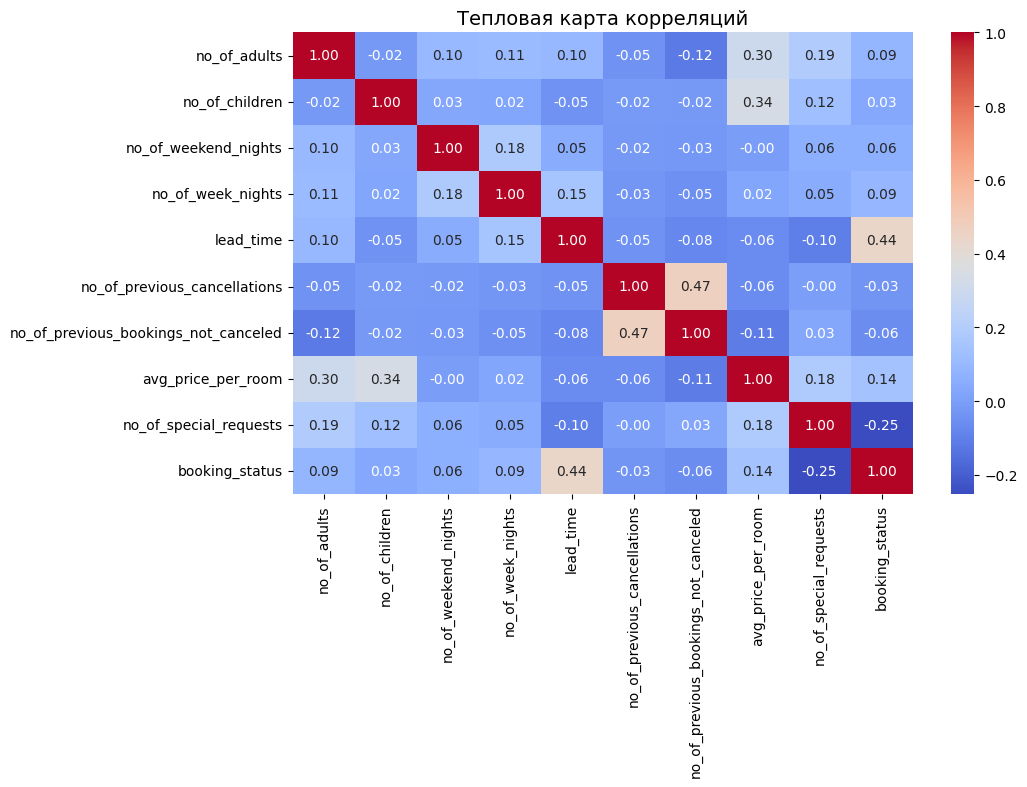

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_columns + ['booking_status']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляций', fontsize=14)
plt.show()

Средняя корреляция наблюдается в фиче времени ожидания. Но так как такие метрики, как количество детей, взрослых, ночей, являются нестандартными, практически некатегориальными, посчитаем для них разброс долей

In [48]:
# Рассчитаем долю отмен для указанных числовых переменных, сгруппированных по уникальным значениям
numerical_columns = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_special_requests']

# Словарь для хранения разброса долей отмен для каждой переменной
spread_stats = {}

# Вычисляем разброс долей отмен
for col in numerical_columns:
    cancellation_rate = df.groupby(col)['booking_status'].mean() * 100
    spread_stats[col] = cancellation_rate.max() - cancellation_rate.min()

spread_stats

{'no_of_adults': np.float64(18.49643936124299),
 'no_of_children': np.float64(50.0),
 'no_of_weekend_nights': np.float64(69.81389284020864),
 'no_of_week_nights': np.float64(72.8920741989882),
 'no_of_special_requests': np.float64(43.2067553218385)}

Разброс долей показывает, что такие фичи как количество детей, количество забронированных ночей и количество пожеланий гостя также являются важными метриками для анализа

Проанализируем календарные даты

In [49]:
df['arrival_date_full'] = pd.to_datetime(
    df[['arrival_year', 'arrival_month', 'arrival_date']].rename(columns={
        'arrival_year': 'year', 'arrival_month': 'month', 'arrival_date': 'day'
    }),
    errors='coerce'
)

In [50]:
df_cleaned = df.dropna(subset=['arrival_date_full'])

# Рассчитаем корреляцию для признаков, связанных с датой
date_related_columns = ['arrival_month', 'arrival_date', 'day_of_week']
df_cleaned['day_of_week'] = df_cleaned['arrival_date_full'].dt.dayofweek  # 0 - понедельник, 6 - воскресенье

# Рассчитаем долю отмен для каждого дня недели и каждого месяца
day_of_week_cancellation_rate = df_cleaned.groupby('day_of_week')['booking_status'].mean() * 100
month_cancellation_rate = df_cleaned.groupby('arrival_month')['booking_status'].mean() * 100

# Округлим значения для наглядности
day_of_week_cancellation_rate = day_of_week_cancellation_rate.round(2)
month_cancellation_rate = month_cancellation_rate.round(2)

# Представим результат для сравнения
day_of_week_cancellation_rate, month_cancellation_rate


/tmp/ipykernel_4284/1344131023.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['day_of_week'] = df_cleaned['arrival_date_full'].dt.dayofweek  # 0 - понедельник, 6 - воскресенье


(day_of_week
 0    30.76
 1    32.37
 2    32.79
 3    31.47
 4    31.79
 5    31.92
 6    37.34
 Name: booking_status, dtype: float64,
 arrival_month
 1      2.37
 2     25.37
 3     29.69
 4     36.37
 5     36.49
 6     40.31
 7     45.00
 8     39.02
 9     33.36
 10    35.36
 11    29.36
 12    13.31
 Name: booking_status, dtype: float64)

Если по дню недели мы видим, что доли +- одинаковы, что означает, что день недели особо не влияет на отмену, то с месяцем наоборот - значения варьируются от 2% в январе до 45 процентов в июле, а это значит, что месяц значительно влияет на отмену бронирования

P.S. Год учитывать не будем - в бизнес-задачу не входит предсказание бронирования в прошлом

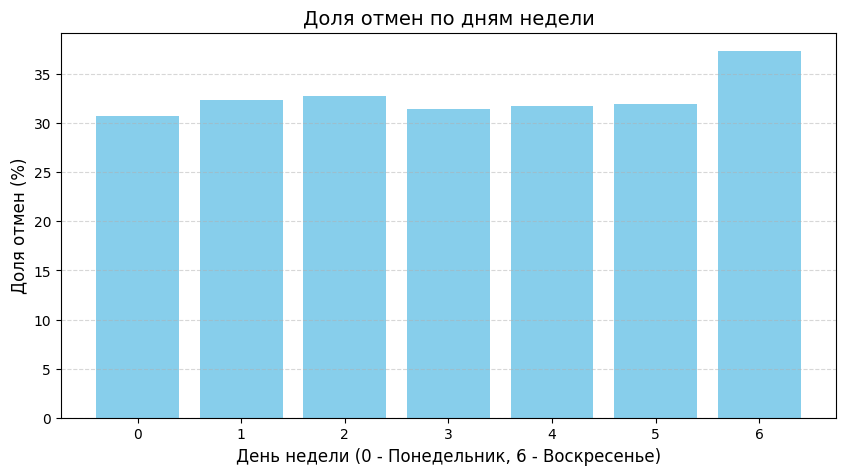

In [51]:
# Создадим график для доли отмен по дням недели
plt.figure(figsize=(10, 5))
plt.bar(day_of_week_cancellation_rate.index, day_of_week_cancellation_rate.values, color='skyblue')
plt.title('Доля отмен по дням недели', fontsize=14)
plt.xlabel('День недели (0 - Понедельник, 6 - Воскресенье)', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.xticks(day_of_week_cancellation_rate.index)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

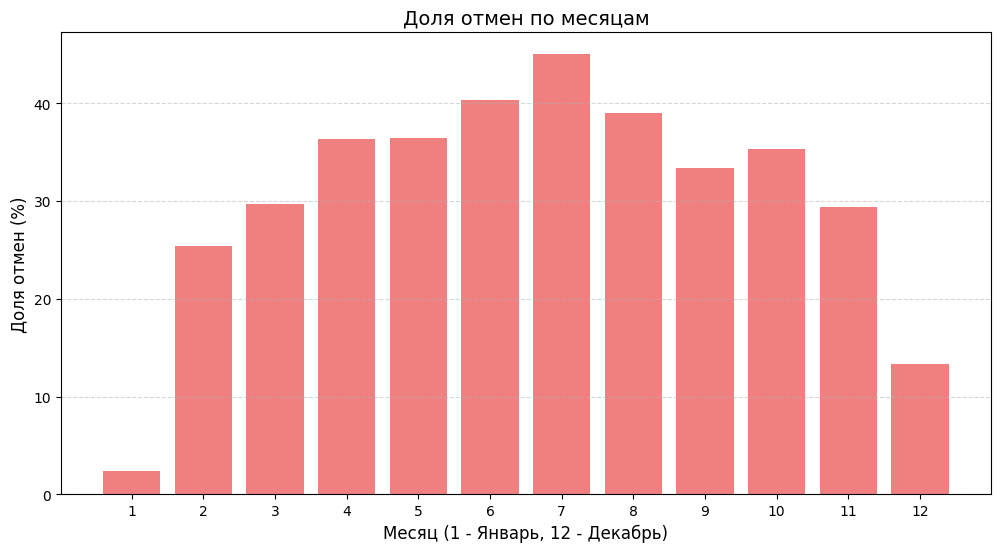

In [52]:
# Создадим график для доли отмен по месяцам
plt.figure(figsize=(12, 6))
plt.bar(month_cancellation_rate.index, month_cancellation_rate.values, color='lightcoral')
plt.title('Доля отмен по месяцам', fontsize=14)
plt.xlabel('Месяц (1 - Январь, 12 - Декабрь)', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.xticks(month_cancellation_rate.index)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Анализ категориальных метрик

### Создадим графики для категориальных метрик


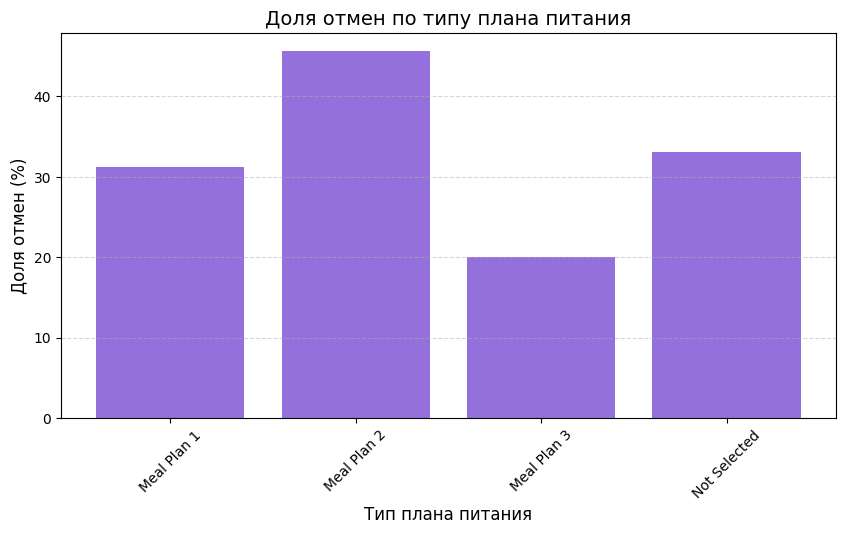

In [53]:
# 1. Доля отмен по типу плана питания
meal_plan_stats = df_cleaned.groupby('type_of_meal_plan')['booking_status'].mean() * 100
plt.figure(figsize=(10, 5))
plt.bar(meal_plan_stats.index, meal_plan_stats.values, color='mediumpurple')
plt.title('Доля отмен по типу плана питания', fontsize=14)
plt.xlabel('Тип плана питания', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


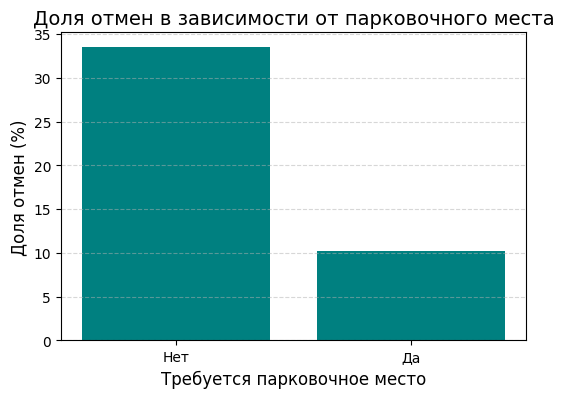

In [54]:
# 2. Доля отмен в зависимости от парковочного места
parking_stats = df_cleaned.groupby('required_car_parking_space')['booking_status'].mean() * 100
plt.figure(figsize=(6, 4))
plt.bar(['Нет', 'Да'], parking_stats.values, color='teal')
plt.title('Доля отмен в зависимости от парковочного места', fontsize=14)
plt.xlabel('Требуется парковочное место', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


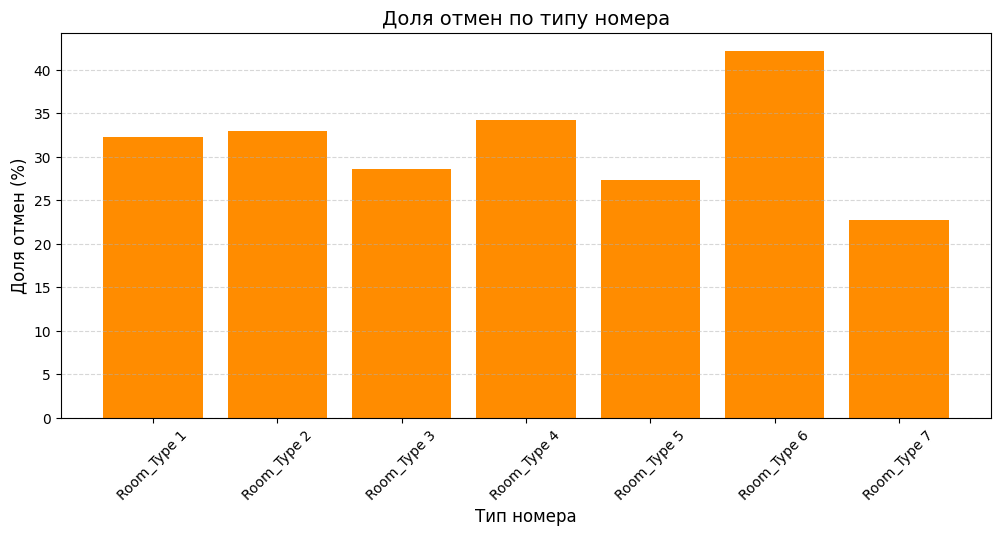

In [55]:
# 3. Доля отмен по типу номера
room_type_stats = df_cleaned.groupby('room_type_reserved')['booking_status'].mean() * 100
plt.figure(figsize=(12, 5))
plt.bar(room_type_stats.index, room_type_stats.values, color='darkorange')
plt.title('Доля отмен по типу номера', fontsize=14)
plt.xlabel('Тип номера', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

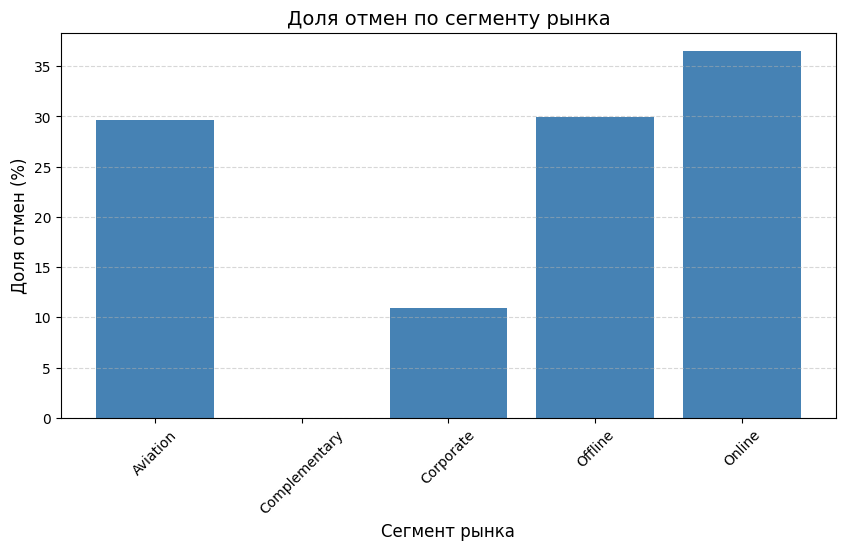

In [56]:
# 4. Доля отмен по сегменту рынка
market_segment_stats = df_cleaned.groupby('market_segment_type')['booking_status'].mean() * 100
plt.figure(figsize=(10, 5))
plt.bar(market_segment_stats.index, market_segment_stats.values, color='steelblue')
plt.title('Доля отмен по сегменту рынка', fontsize=14)
plt.xlabel('Сегмент рынка', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

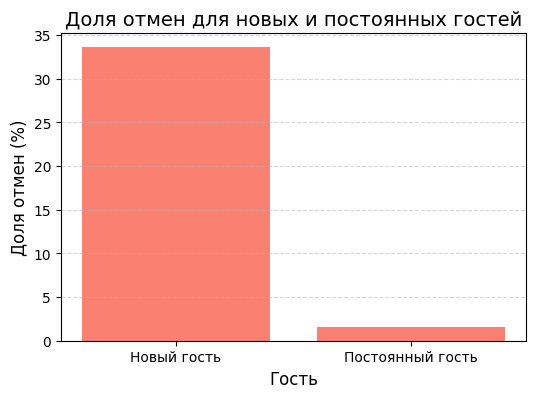

In [57]:
# 5. Доля отмен для постоянных и новых гостей
guest_stats = df_cleaned.groupby('repeated_guest')['booking_status'].mean() * 100
plt.figure(figsize=(6, 4))
plt.bar(['Новый гость', 'Постоянный гость'], guest_stats.values, color='salmon')
plt.title('Доля отмен для новых и постоянных гостей', fontsize=14)
plt.xlabel('Гость', fontsize=12)
plt.ylabel('Доля отмен (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


По графикам можно сделать вывод, что важными метриками являются тип бронирования, тип гостей, необходимость парковочного места

Тип номера и выбранного обеда показали наименьший разброс долей - его не будем использовать

# Итоговые метрики для обучения

Таким образом выбранные метрики для обучения модели:
1. Количество детей
2. Количество ночей на выходных
3. Количество ночей в будние дни
4. Месяц
5. Тип бронирования
6. Постоянный клиент
7. Парковочное место

# EDA

In [58]:
import scipy.stats as stats

/tmp/ipykernel_4284/1953906999.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='no_of_children', data=df_cleaned, palette='pastel')


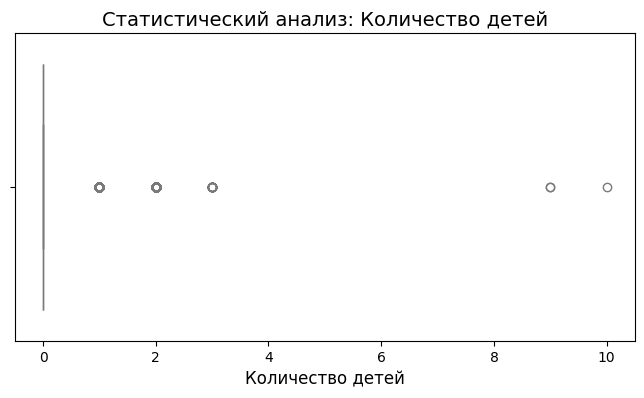

count    36238.000000
mean         0.105221
std          0.402540
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: no_of_children, dtype: float64

In [59]:


# 1. Количество детей
children_stats = df_cleaned['no_of_children'].describe()
plt.figure(figsize=(8, 4))
sns.boxplot(x='no_of_children', data=df_cleaned, palette='pastel')
plt.title('Статистический анализ: Количество детей', fontsize=14)
plt.xlabel('Количество детей', fontsize=12)
plt.show()
children_stats



/tmp/ipykernel_4284/2302435828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='no_of_weekend_nights', data=df_cleaned, palette='muted')


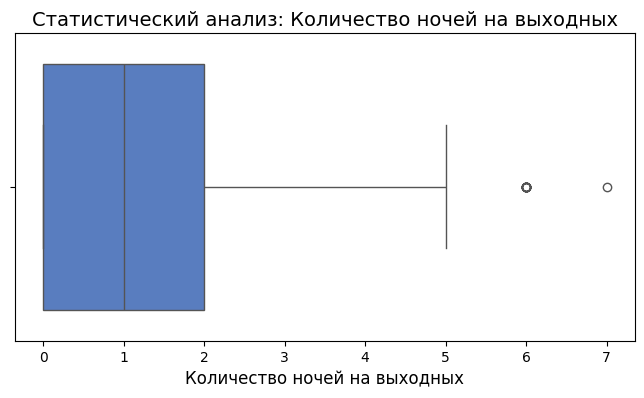

count    36238.000000
mean         0.810475
std          0.870992
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: no_of_weekend_nights, dtype: float64

In [60]:
# 2. Количество ночей на выходных
weekend_nights_stats = df_cleaned['no_of_weekend_nights'].describe()
plt.figure(figsize=(8, 4))
sns.boxplot(x='no_of_weekend_nights', data=df_cleaned, palette='muted')
plt.title('Статистический анализ: Количество ночей на выходных', fontsize=14)
plt.xlabel('Количество ночей на выходных', fontsize=12)
plt.show()
weekend_nights_stats


/tmp/ipykernel_4284/2333919491.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='no_of_week_nights', data=df_cleaned, palette='coolwarm')


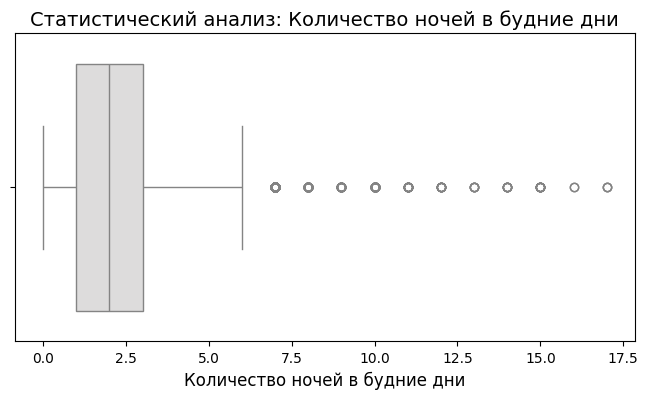

count    36238.000000
mean         2.204206
std          1.410784
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         17.000000
Name: no_of_week_nights, dtype: float64

In [61]:

# 3. Количество ночей в будние дни
week_nights_stats = df_cleaned['no_of_week_nights'].describe()
plt.figure(figsize=(8, 4))
sns.boxplot(x='no_of_week_nights', data=df_cleaned, palette='coolwarm')
plt.title('Статистический анализ: Количество ночей в будние дни', fontsize=14)
plt.xlabel('Количество ночей в будние дни', fontsize=12)
plt.show()
week_nights_stats



/tmp/ipykernel_4284/3605368190.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='arrival_month', data=df_cleaned, palette='viridis')


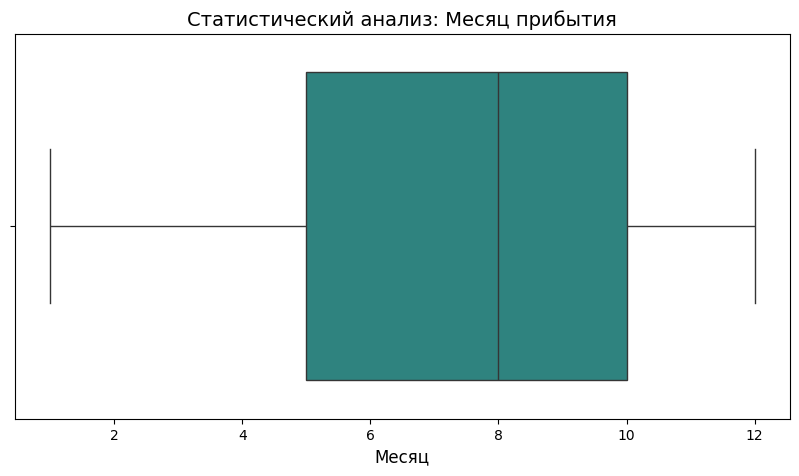

count    36238.000000
mean         7.429190
std          3.066563
min          1.000000
25%          5.000000
50%          8.000000
75%         10.000000
max         12.000000
Name: arrival_month, dtype: float64

In [62]:
# 4. Месяц
month_stats = df_cleaned['arrival_month'].describe()
plt.figure(figsize=(10, 5))
sns.boxplot(x='arrival_month', data=df_cleaned, palette='viridis')
plt.title('Статистический анализ: Месяц прибытия', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.show()
month_stats



/tmp/ipykernel_4284/3101441373.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=market_segment_stats.index, y=market_segment_stats.values, palette='plasma')


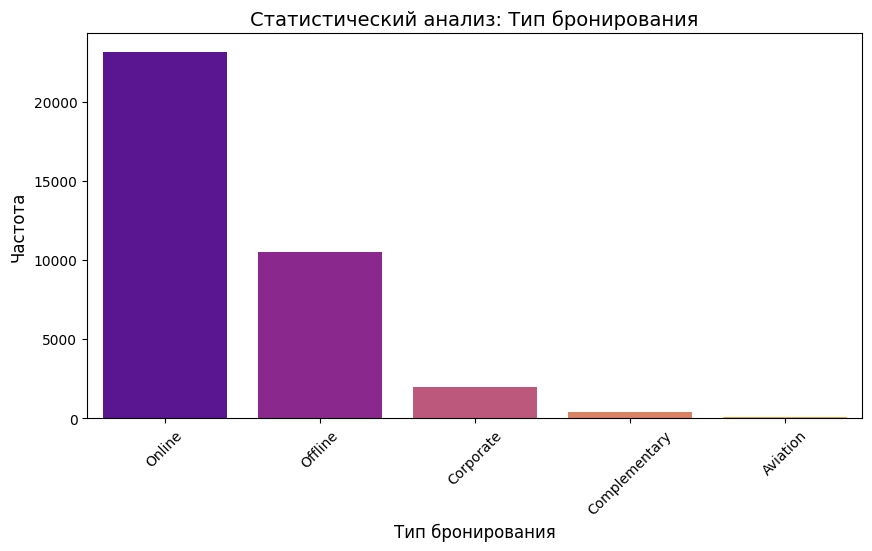

In [63]:
# 5. Тип бронирования (market_segment_type)
market_segment_stats = df_cleaned['market_segment_type'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=market_segment_stats.index, y=market_segment_stats.values, palette='plasma')
plt.title('Статистический анализ: Тип бронирования', fontsize=14)
plt.xlabel('Тип бронирования', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.xticks(rotation=45)
plt.show()



/tmp/ipykernel_4284/1200634626.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=repeated_guest_stats.index, y=repeated_guest_stats.values, palette='autumn')


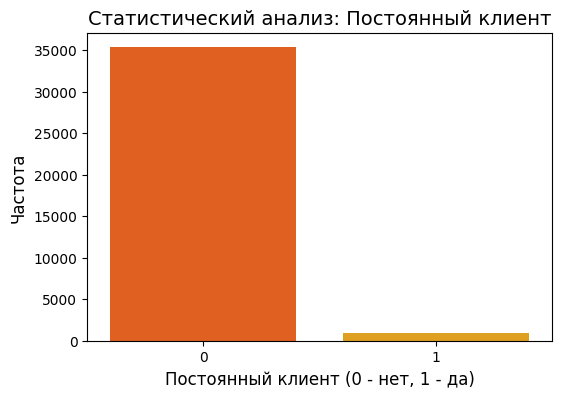

In [64]:
# 6. Постоянный клиент (repeated_guest)
repeated_guest_stats = df_cleaned['repeated_guest'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=repeated_guest_stats.index, y=repeated_guest_stats.values, palette='autumn')
plt.title('Статистический анализ: Постоянный клиент', fontsize=14)
plt.xlabel('Постоянный клиент (0 - нет, 1 - да)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()




/tmp/ipykernel_4284/1702058380.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=parking_space_stats.index, y=parking_space_stats.values, palette='summer')


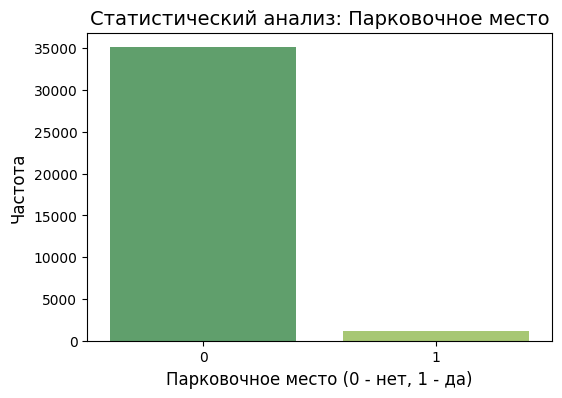

In [65]:
# 7. Парковочное место (required_car_parking_space)
parking_space_stats = df_cleaned['required_car_parking_space'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=parking_space_stats.index, y=parking_space_stats.values, palette='summer')
plt.title('Статистический анализ: Парковочное место', fontsize=14)
plt.xlabel('Парковочное место (0 - нет, 1 - да)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()


### Текстовый анализ переменных

1. **Количество детей (`no_of_children`)**:
   - **Описание**: Среднее значение составляет 0.11, что указывает на то, что в большинстве бронирований дети отсутствуют. Медианное значение также равно 0, а 75-й перцентиль всё ещё равен 0, что подтверждает, что более 75% бронирований не включают детей.
   - **Аномалии**: Максимальное значение составляет 10 детей, что может быть аномалией или редким случаем группового бронирования для большой семьи. Учитывая низкую частоту таких случаев, стоит проверить корректность данных для этого признака, так как это может искажать некоторые статистические анализы.

2. **Количество ночей на выходных (`no_of_weekend_nights`)**:
   - **Описание**: Среднее значение равно 0.81 ночей, что свидетельствует о том, что большинство гостей останавливаются на одну или две ночи на выходных. Медиана равна 1, и большая часть бронирований сосредоточена в диапазоне от 0 до 2 ночей.
   - **Аномалии**: Максимум в 7 ночей на выходных может быть подозрительным, так как обычно бронируют 2 ночи за выходные. Такие данные могут быть ошибками ввода или редкими случаями долгосрочного проживания, например, при бронировании корпоративных мероприятий.

3. **Количество ночей в будние дни (`no_of_week_nights`)**:
   - **Описание**: Среднее значение составляет 2.20 ночей, с более чем 50% бронирований на 2 или 3 ночи. Однако разброс значителен: максимум достигает 17 ночей, что выходит за пределы нормального диапазона.
   - **Аномалии**: Значения выше 10 ночей в будние дни могут быть аномалиями, особенно если это не типично для данного отеля. Такие записи следует дополнительно проанализировать, чтобы убедиться в корректности данных или понять особые условия длительного проживания.

4. **Месяц прибытия (`arrival_month`)**:
   - **Описание**: Среднее значение равно 7.43, что указывает на более высокую активность бронирований в летние месяцы (июль, август). Распределение данных показывает сезонность: более высокий спрос в летние и осенние месяцы.
   - **Аномалии**: Значительных аномалий нет, но можно отметить неравномерность спроса в течение года, которая может быть связана с сезонностью, праздничными периодами или школьными каникулами.

### Анализ категориальных переменных

5. **Тип бронирования (`market_segment_type`)**:
   - **Описание**: Бронирования сильно сосредоточены в онлайн и офлайн сегментах, что соответствует текущим трендам в индустрии. Типы, такие как "Aviation" и "Complementary", имеют наименьшее количество записей.
   - **Аномалии**: Небольшое количество бронирований в некоторых сегментах может указывать на редкость таких случаев или на специфические условия, которые не типичны для большинства клиентов.

6. **Постоянные гости (`repeated_guest`)**:
   - **Описание**: Большинство гостей — новые, что типично для большинства отелей. Постоянные гости составляют небольшую часть бронирований.
   - **Аномалии**: Нет значительных аномалий, но стоит учитывать, что постоянные гости могут иметь особые условия или льготы, что может повлиять на их поведение при бронировании.

7. **Парковочное место (`required_car_parking_space`)**:
   - **Описание**: Только небольшая доля гостей запрашивает парковочное место, что может быть связано с городским расположением отеля или с ориентацией на гостей, приезжающих общественным транспортом.
   - **Аномалии**: Здесь нет значительных аномалий, но можно изучить, как наличие парковки влияет на другие параметры бронирования, особенно для корпоративных клиентов или групповых бронирований.

### Итог
- Анализ выявил некоторые потенциальные аномалии в данных, такие как большое количество детей или ночей в будние дни, которые могут быть редкими случаями или ошибками ввода. Эти случаи требуют дополнительной проверки. В остальном, данные демонстрируют типичное поведение гостей с сезонными колебаниями и высокой долей бронирований через онлайн-каналы.